In [3]:
import warnings
from datetime import datetime, timedelta
from typing import List, Optional, Tuple, Union

import cvxpy as cp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.figure_factory as ff
import plotly.graph_objects as go
import pypfopt as ppo
import yfinance as yf
from plotly.subplots import make_subplots
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import squareform
from sklearn.covariance import ledoit_wolf

In [4]:
tech = np.array(["IYW", "VGT"])
real_estate = np.array(["IYR"])
bank_finance = np.array(["IYF"])
utilities = np.array(["XLU"])
consumer_staples = np.array(["IYK"])

tickers = np.concatenate([tech, real_estate, bank_finance, utilities, consumer_staples], axis=0)
tickers.shape

(6,)

In [5]:
start_date = (datetime.now() - timedelta(days=365.25 * 5)).strftime("%Y-%m-%d")

daily_prices = yf.download(", ".join(tickers), start=start_date, auto_adjust=False)["Adj Close"]

[*********************100%***********************]  6 of 6 completed


In [12]:
daily_prices

Ticker,IYF,IYK,IYR,IYW,VGT,XLU
Date,,,,,,
2020-09-08,53.414772,42.996632,71.634857,71.322083,288.962158,50.557041
2020-09-09,54.042149,44.044678,72.286179,73.442436,298.084991,51.224960
2020-09-10,53.193348,43.832691,71.318008,72.050133,291.797394,50.342964
2020-09-11,53.322510,44.056629,70.921959,71.491234,289.455261,50.462837
2020-09-14,54.268188,45.015091,72.823051,72.631081,295.612671,51.156460
...,...,...,...,...,...,...
2025-08-29,125.730003,70.339996,97.639999,181.789993,697.020020,84.320000
2025-09-02,124.820000,70.410004,95.970001,179.960007,689.809998,84.040001
2025-09-03,124.650002,70.040001,96.029999,181.820007,692.900024,83.830002


In [6]:
daily_prices.isna().sum(axis=0)

,0
Ticker,
IYF,0
IYK,0
IYR,0
IYW,0
VGT,0
XLU,0


In [7]:
(daily_prices == 0).sum(axis=0)

,0
Ticker,
IYF,0
IYK,0
IYR,0
IYW,0
VGT,0
XLU,0


In [8]:
fig = make_subplots(rows=3, cols=2, subplot_titles=tickers)

for i, ticker in enumerate(tickers):
    row = i // 2 + 1
    col = i % 2 + 1
    fig.add_trace(
        go.Scatter(x=daily_prices.index, y=daily_prices.loc[:, ticker], name=ticker),
        row=row,
        col=col,
    );

fig.update_layout(height=1000, autosize=True, title_text="Daily Prices");

fig.show()

In [10]:
daily_returns = daily_prices.pct_change().dropna(how="all")

In [11]:
daily_returns

Ticker,IYF,IYK,IYR,IYW,VGT,XLU
Date,,,,,,
2020-09-09,0.011745,0.024375,0.009092,0.029729,0.031571,0.013211
2020-09-10,-0.015706,-0.004813,-0.013394,-0.018958,-0.021093,-0.017218
2020-09-11,0.002428,0.005109,-0.005553,-0.007757,-0.008027,0.002381
2020-09-14,0.017735,0.021755,0.026805,0.015944,0.021272,0.013745
2020-09-15,-0.005100,0.008358,0.011603,0.013196,0.010921,0.006696
...,...,...,...,...,...,...
2025-08-29,0.000955,0.009472,0.005561,-0.014955,-0.015328,-0.003663
2025-09-02,-0.007238,0.000995,-0.017104,-0.010066,-0.010344,-0.003321
2025-09-03,-0.001362,-0.005255,0.000625,0.010336,0.004480,-0.002499


In [13]:
annualized_mean_returns = (1 + daily_returns).prod() ** (
    252 / daily_returns.count()
) - 1

annualized_mean_returns

,0
Ticker,
IYF,0.184256
IYK,0.103088
IYR,0.064478
IYW,0.208261
VGT,0.194175
XLU,0.106008


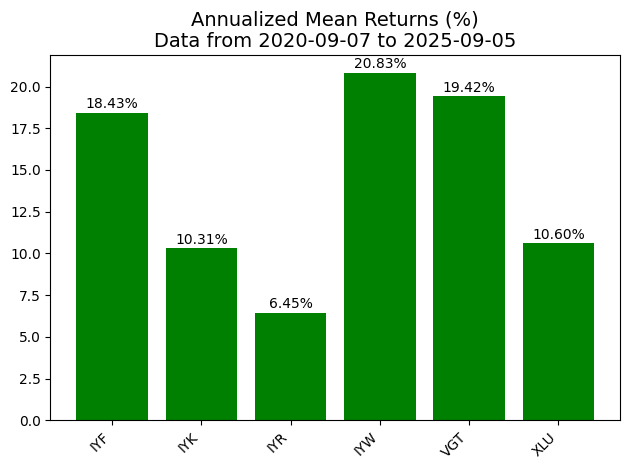

In [14]:
conditional_colors = ["green" if value > 0 else "red" for value in annualized_mean_returns]

fig, ax = plt.subplots();

bars = ax.bar(
    annualized_mean_returns.index,
    annualized_mean_returns * 100,  # Convert to percentage
    color=conditional_colors
);

for bar in bars:
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        height + np.sign(height) * 0.1,  # Add spacing to the value
        f'{height:.2f}%',
        ha='center', va='bottom' if height > 0 else 'top',  # Adjust placement for negative values
        fontsize=10
    );

title_text = f"Annualized Mean Returns (%)\nData from {start_date} to {daily_returns.index.max().strftime('%Y-%m-%d')}"
ax.set_title(title_text, fontsize=14);
plt.xticks(rotation=45, ha='right');
plt.tight_layout();
plt.show()

In [15]:
def to_dataframe(matrix: Union[np.ndarray, pd.DataFrame], columns: pd.Index) -> pd.DataFrame:
    return pd.DataFrame(matrix, index=columns, columns=columns)

# Shrinkage covariance matrix
shrinkage_covariance_matrix, _ = ledoit_wolf(
    X=daily_returns,
    assume_centered=False,
)

# Shrinkage correlation matrix
dinv = np.diag(1 / np.sqrt(np.diag(shrinkage_covariance_matrix)))
shrinkage_correlation_matrix = np.dot(dinv, np.dot(shrinkage_covariance_matrix, dinv))

columns = daily_returns.columns
shrinkage_covariance_matrix = to_dataframe(shrinkage_covariance_matrix, columns)
shrinkage_correlation_matrix = to_dataframe(shrinkage_correlation_matrix, columns)

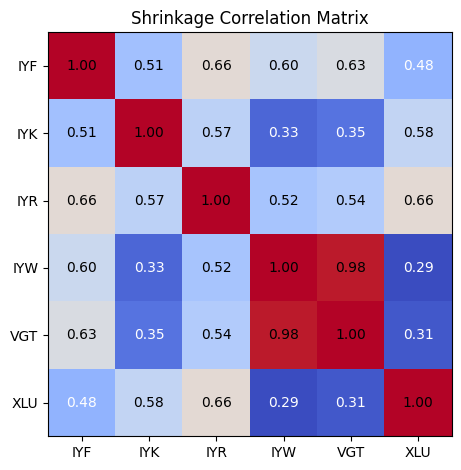

In [16]:
fig, ax = plt.subplots();
cax = ax.matshow(shrinkage_correlation_matrix, cmap="coolwarm");
ax.xaxis.set_ticks_position('bottom');
ax.set_xticks(np.arange(len(shrinkage_correlation_matrix.columns)));
ax.set_yticks(np.arange(len(shrinkage_correlation_matrix.columns)));
ax.set_xticklabels(shrinkage_correlation_matrix.columns);
ax.set_yticklabels(shrinkage_correlation_matrix.columns);

for i in range(shrinkage_correlation_matrix.shape[0]):
    for j in range(shrinkage_correlation_matrix.shape[1]):
        # Ensure text can be easily seen
        value = shrinkage_correlation_matrix.iloc[i, j]
        color = "white" if value < 0.5 else "black"
        ax.text(j, i, f"{value:.2f}", ha="center", va="center", color=color);

plt.title("Shrinkage Correlation Matrix");
plt.tight_layout();
plt.show()

In [17]:
dist_matrix = np.sqrt((1.0 - shrinkage_correlation_matrix.round(8)) / 2.0)
dist_matrix

Ticker,IYF,IYK,IYR,IYW,VGT,XLU
Ticker,,,,,,
IYF,0.000000,0.494994,0.411759,0.447433,0.429889,0.511887
IYK,0.494994,0.000000,0.465984,0.577536,0.568332,0.458117
IYR,0.411759,0.465984,0.000000,0.489663,0.477712,0.411676
IYW,0.447433,0.577536,0.489663,0.000000,0.087690,0.596427
VGT,0.429889,0.568332,0.477712,0.087690,0.000000,0.587641
XLU,0.511887,0.458117,0.411676,0.596427,0.587641,0.000000


In [18]:
condensed_dist_matrix = squareform(X=dist_matrix, checks=False)
condensed_dist_matrix

array([0.49499374, 0.41175861, 0.44743263, 0.42988872, 0.51188683,
       0.46598354, 0.57753606, 0.56833183, 0.45811651, 0.48966311,
       0.47771249, 0.41167647, 0.08768977, 0.59642743, 0.58764059])

In [19]:
linkage_matrix = linkage(y=condensed_dist_matrix, method="ward")

linkage_matrix

array([[3.        , 4.        , 0.08768977, 2.        ],
       [2.        , 5.        , 0.41167647, 2.        ],
       [1.        , 7.        , 0.47768374, 3.        ],
       [0.        , 8.        , 0.48875477, 4.        ],
       [6.        , 9.        , 0.72079957, 6.        ]])

In [20]:
linkage_matrix

array([[3.        , 4.        , 0.08768977, 2.        ],
       [2.        , 5.        , 0.41167647, 2.        ],
       [1.        , 7.        , 0.47768374, 3.        ],
       [0.        , 8.        , 0.48875477, 4.        ],
       [6.        , 9.        , 0.72079957, 6.        ]])

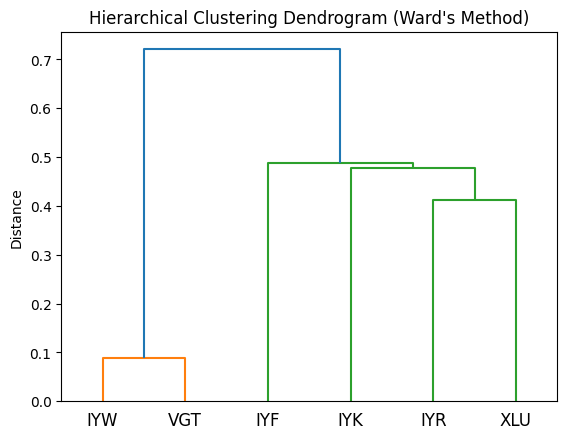

In [21]:
fig, ax = plt.subplots();
dendrogram(linkage_matrix, labels=shrinkage_correlation_matrix.columns, orientation='top');
plt.title("Hierarchical Clustering Dendrogram (Ward's Method)");
plt.ylabel("Distance");
plt.show()

In [22]:
def get_quasi_diag(linkage_matrix: np.ndarray) -> List[int]:
    """
    Sort clustered items by distance based on the linkage matrix.

    Parameters
    ----------
    linkage_matrix : np.ndarray
        The linkage matrix from hierarchical clustering.

    Returns
    -------
    List[int]
        The sorted indices of the clustered items.
    """
    linkage_matrix = linkage_matrix.astype(int)

    sorted_index = pd.Series([linkage_matrix[-1, 0], linkage_matrix[-1, 1]])
    print(f"Initial sorted index (last two merged clusters): {sorted_index.tolist()}")
    num_items = linkage_matrix[-1, 3]
    print(f"Initial total number of original items: {num_items}")
    # Recursively sort clusters by distance until no clusters remain
    while sorted_index.max() >= num_items:
        print("\n--- New iteration ---\n")

        # Reassign the series index to a range with gaps (0, 2, 4, ...)
        # Creates empty positions between the current elements
        # The gaps allow new elements to be inserted without overwriting existing ones
        # It is needed in quasi-diagonalization to insert the second constituent of clusters
        # The operation helps maintain the correct hierarchical ordering of the items
        sorted_index.index = range(0, sorted_index.shape[0] * 2, 2)
        print(f"Expanded sorted index positions (with gaps): {sorted_index.tolist()}")

        # Filter sorted_index to select only indices corresponding to merged clusters (i.e., indices >= num_items)
        # Original items have indices from 0 to num_items - 1, any value that is >= num_items corresponds to a merged cluster
        # The cluster_indices will contain only those elements that still need to be "unpacked" into their constituent parts
        cluster_indices = sorted_index[sorted_index >= num_items]
        i = cluster_indices.index  # Indices in sorted_index where clusters need to be expanded
        j = cluster_indices.values - num_items # Row numbers in linkage_matrix to retrieve cluster members
        print(f"Identified clusters to expand:")
        print(f"    Positions in sorted_index (i): {i.tolist()}")
        print(f"    Corresponding linkage matrix row numbers (j): {j.tolist()}")
        # Replace clusters with their first constituent
        for idx, row_num in zip(i, j):
            row_dict = {
                'merged_1': linkage_matrix[row_num, 0],
                'merged_2': linkage_matrix[row_num, 1],
                'number_of_original': linkage_matrix[row_num, 3]
            }
            original_cluster = sorted_index[idx]
            first_constituent = linkage_matrix[row_num, 0]
            print(f"      Row {row_num} of the linkage matrix: {row_dict}")
            print(f"      Cluster {original_cluster} was formed by merging {linkage_matrix[row_num, 0]} and {linkage_matrix[row_num, 1]}")
            print(f"      Replacing cluster {original_cluster} with its first constituent: {first_constituent}")
            sorted_index[idx] = first_constituent
        print(f"After replacing clusters with their first constituents: {sorted_index.tolist()}")

        # Append the second constituent of the clusters
        second_constituents = pd.Series(linkage_matrix[j, 1], index=i + 1)
        sorted_index = pd.concat([sorted_index, second_constituents])
        for idx, second_constituent in second_constituents.items():
            print(f"      Appending second constituent {second_constituent}")
        print(f"After appending the second constituents: {sorted_index.tolist()}")

        # In quasi-diagonalization, we recursively unpack clusters to reveal the underlying order
        # After inserting new elements into the series with gaps, the positions may no longer be in sequential order
        # Sorting the series by its index re-establishes the intended order based on the gaps we created
        # Resetting the index to a continuous range (0, 1, 2, ...) removes the gaps and standardizes the positions
        # This ensures that in the next iteration, we can correctly identify which elements are still clusters to unpack
        sorted_index = sorted_index.sort_index()
        sorted_index.index = range(sorted_index.shape[0])
        print(f"Final sorted index after re-sorting: {sorted_index.tolist()}")

    return sorted_index.tolist()

In [23]:
linkage_matrix

array([[3.        , 4.        , 0.08768977, 2.        ],
       [2.        , 5.        , 0.41167647, 2.        ],
       [1.        , 7.        , 0.47768374, 3.        ],
       [0.        , 8.        , 0.48875477, 4.        ],
       [6.        , 9.        , 0.72079957, 6.        ]])

In [24]:
sorted_index = get_quasi_diag(linkage_matrix)

Initial sorted index (last two merged clusters): [6, 9]
Initial total number of original items: 6

--- New iteration ---

Expanded sorted index positions (with gaps): [6, 9]
Identified clusters to expand:
    Positions in sorted_index (i): [0, 2]
    Corresponding linkage matrix row numbers (j): [0, 3]
      Row 0 of the linkage matrix: {'merged_1': np.int64(3), 'merged_2': np.int64(4), 'number_of_original': np.int64(2)}
      Cluster 6 was formed by merging 3 and 4
      Replacing cluster 6 with its first constituent: 3
      Row 3 of the linkage matrix: {'merged_1': np.int64(0), 'merged_2': np.int64(8), 'number_of_original': np.int64(4)}
      Cluster 9 was formed by merging 0 and 8
      Replacing cluster 9 with its first constituent: 0
After replacing clusters with their first constituents: [3, 0]
      Appending second constituent 4
      Appending second constituent 8
After appending the second constituents: [3, 0, 4, 8]
Final sorted index after re-sorting: [3, 4, 0, 8]

--- New 

In [25]:
sorted_index

[3, 4, 0, 1, 2, 5]

In [26]:
sorted_correlation_matrix = shrinkage_correlation_matrix.iloc[sorted_index, sorted_index]

In [27]:
sorted_correlation_matrix

Ticker,IYW,VGT,IYF,IYK,IYR,XLU
Ticker,,,,,,
IYW,1.000000,0.984621,0.599608,0.332904,0.520460,0.288549
VGT,0.984621,1.000000,0.630391,0.353998,0.543582,0.309357
IYF,0.599608,0.630391,1.000000,0.509962,0.660910,0.475944
IYK,0.332904,0.353998,0.509962,1.000000,0.565719,0.580259
IYR,0.520460,0.543582,0.660910,0.565719,1.000000,0.661045
XLU,0.288549,0.309357,0.475944,0.580259,0.661045,1.000000


In [28]:
ordered_tickers = shrinkage_correlation_matrix.index[sorted_index]
ordered_tickers

Index(['IYW', 'VGT', 'IYF', 'IYK', 'IYR', 'XLU'], dtype='object', name='Ticker')

In [29]:
def get_ivp(cov: pd.DataFrame) -> np.ndarray:
    """
    Compute the inverse variance portfolio (IVP) for a given covariance matrix.

    Parameters
    ----------
    cov : pd.DataFrame
        Covariance matrix of the cluster.

    Returns
    -------
    np.ndarray
        Inverse variance portfolio weights for the cluster.
    """
    ivp = 1.0 / np.diag(cov)
    ivp /= ivp.sum()  # Normalize weights
    print(f"\n    IVP weights for cluster: {ivp}")
    return ivp

In [30]:
def get_cluster_var(cov: pd.DataFrame, cluster_items: List[str]) -> float:
    """
    Compute the variance for a given cluster.

    Parameters
    ----------
    cov : pd.DataFrame
        Covariance matrix for the assets.
    cluster_items : List[str]
        List of tickers in the cluster.

    Returns
    -------
    float
        The variance of the cluster.
    """
    # Subset of the covariance matrix containing only the cluster assets
    cov_slice = cov.loc[cluster_items, cluster_items]
    # Define the left space (4 spaces in this case)
    hspace = "    "
    formatted_cov_slice = str(cov_slice).replace("\n", "\n" + hspace)
    print(f"\n    Covariance matrix slice for cluster {cluster_items}:\n{hspace}{formatted_cov_slice}")
    # Calculate inverse variance portfolio (IVP) weights for the cluster and reshape to column vector (n x 1)
    weights = get_ivp(cov_slice).reshape(-1, 1)
    # Compute cluster variance as w.T * cov_slice * w, which is [1 x n] * [n x n] * [n x 1] = [1 x 1]
    cluster_var = np.dot(np.dot(weights.T, cov_slice), weights)[0, 0]
    print(f"\n    Cluster variance for {cluster_items}: {cluster_var}\n")
    return cluster_var

In [31]:
def recursive_bisection(cov: pd.DataFrame, ordered_tickers: Union[pd.Index, List[str]]) -> pd.Series:
    """
    Compute the Hierarchical Risk Parity (HRP) portfolio allocation using recursive bisection.

    Parameters
    ----------
    cov : pd.DataFrame
        Covariance matrix for the assets.
    ordered_tickers : Union[pd.Index, List[str]]
        List of tickers ordered by hierarchical clustering.

    Returns
    -------
    pd.Series
        Portfolio weights for each asset.
    """
    # Initialize equal weights for all assets
    weights = pd.Series(1.0, index=ordered_tickers)
    hspace = "    "  # Define the left space (4 spaces in this case)
    formatted_weights = str(weights).replace("\n", "\n" + hspace)
    print(f"Initial weights:\n{hspace}{formatted_weights}\n")
    # Initialize the cluster as the full set of ordered tickers
    cluster_items = [ordered_tickers]

    step = 0
    while len(cluster_items) > 0:
        step += 1
        print(f"\n{'='*20} Step {step}: Recursive Bisection {'='*20}\n")
        print(f"Cluster items at Step {step}: {[list(cluster) for cluster in cluster_items]}")
        # Split each cluster into two halves only if the cluster contains more than one asset
        cluster_items = [
            i[j:k]
            for i in cluster_items
            for j, k in ((0, len(i) // 2), (len(i) // 2, len(i)))
            if len(i) > 1
        ]
        # For each pair of clusters, calculate variance and adjust weights
        for i in range(0, len(cluster_items), 2):
            first_cluster = cluster_items[i]
            second_cluster = cluster_items[i + 1]
            print(f"\n    ---- Processing clusters ----")
            print(f"    First cluster: {first_cluster}")
            print(f"    Second cluster: {second_cluster}")
            # Compute variance for each cluster
            first_var = get_cluster_var(cov, list(first_cluster))
            second_var = get_cluster_var(cov, list(second_cluster))
            # Compute the weighting factor alpha
            alpha = 1 - first_var / (first_var + second_var)
            print(f"    Weighting factor alpha for {list(first_cluster)}: {alpha}")
            print(f"    Weighting factor 1 - alpha for {list(second_cluster)}: {1 - alpha}")
            # Adjust weights for each cluster
            weights[first_cluster] *= alpha
            weights[second_cluster] *= 1 - alpha
            formatted_weights = str(weights).replace("\n", "\n" + hspace)
            print(f"    Updated weights after adjustment:\n{hspace}{formatted_weights}\n")
    return weights

In [32]:
hrp_weights = recursive_bisection(cov=shrinkage_covariance_matrix, ordered_tickers=ordered_tickers)

Initial weights:
    Ticker
    IYW    1.0
    VGT    1.0
    IYF    1.0
    IYK    1.0
    IYR    1.0
    XLU    1.0
    dtype: float64


==================== Step 1: Recursive Bisection ====================

Cluster items at Step 1: [['IYW', 'VGT', 'IYF', 'IYK', 'IYR', 'XLU']]

    ---- Processing clusters ----
    First cluster: Index(['IYW', 'VGT', 'IYF'], dtype='object', name='Ticker')
    Second cluster: Index(['IYK', 'IYR', 'XLU'], dtype='object', name='Ticker')

    Covariance matrix slice for cluster ['IYW', 'VGT', 'IYF']:
    Ticker       IYW       VGT       IYF
    Ticker                              
    IYW     0.000269  0.000257  0.000121
    VGT     0.000257  0.000253  0.000123
    IYF     0.000121  0.000123  0.000152

    IVP weights for cluster: [0.26036851 0.27772018 0.46191131]

    Cluster variance for ['IYW', 'VGT', 'IYF']: 0.00016812268571718858


    Covariance matrix slice for cluster ['IYK', 'IYR', 'XLU']:
    Ticker       IYK       IYR       XLU
    Ticker    

In [33]:
hrp_weights.sort_index()

,0
Ticker,
IYF,0.124036
IYK,0.410445
IYR,0.125926
IYW,0.112602
VGT,0.074576
XLU,0.152415


In [34]:
hrp = ppo.hierarchical_portfolio.HRPOpt(
  cov_matrix=shrinkage_covariance_matrix,
)

hrp.optimize(linkage_method="ward")

OrderedDict([('IYF', np.float64(0.12403621906898755)),
             ('IYK', np.float64(0.41044475856015084)),
             ('IYR', np.float64(0.12592604470888527)),
             ('IYW', np.float64(0.11260236698743661)),
             ('VGT', np.float64(0.07457570341230703)),
             ('XLU', np.float64(0.1524149072622327))])